In [1]:
import numpy as np
import torch

In [2]:
# SVD 实现正交初始化
def orthogonal_init(shape, gain=1.):
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.normal(0., 1., flat_shape)
    u, d, vt = np.linalg.svd(a, full_matrices=False)
    # pick the one with the correct shape
#     print('u' if u.shape == flat_shape else 'v')
    q = u if u.shape == flat_shape else vt
    q = q.reshape(shape)
    return gain*q

In [3]:
shape = (4, 4) 

In [4]:
x = orthogonal_init(shape)

In [5]:
# pytorch 正交初始化(PQ 分解)
w = torch.empty(shape)
torch.nn.init.orthogonal_(w)

tensor([[-0.2595,  0.1582, -0.9472, -0.1019],
        [-0.5655, -0.8124,  0.0341, -0.1377],
        [ 0.2688, -0.0229,  0.0260, -0.9626],
        [ 0.7352, -0.5607, -0.3176,  0.2101]])

In [6]:
np.linalg.det(x), np.linalg.det(w)

(-1.0000000000000013, -0.9999998)

In [7]:
np.linalg.det(x@x@x@x)

1.0000000000000049

行列式为+-1, 不缩放

In [8]:
# 特征值分解
e_value, e_vector = np.linalg.eig(w)

In [9]:
print(np.allclose(e_vector@np.diag(e_value)@np.linalg.inv(e_vector), w))
e_vector@np.diag(e_value)@np.linalg.inv(e_vector)

True


array([[-0.25949994+0.j,  0.15816268+0.j, -0.9472421 +0.j,
        -0.10186458+0.j],
       [-0.5655285 +0.j, -0.8124354 +0.j,  0.0340839 +0.j,
        -0.13771187+0.j],
       [ 0.26883373+0.j, -0.02288072+0.j,  0.02604392+0.j,
        -0.9625625 +0.j],
       [ 0.73523176+0.j, -0.56072265+0.j, -0.3176351 +0.j,
         0.21007702+0.j]], dtype=complex64)

In [10]:
np.allclose(w@w, e_vector@(np.diag(e_value)**2)@np.linalg.inv(e_vector))

True

https://smerity.com/articles/2016/orthogonal_init.html

$
\begin{aligned}
F^{2} &=\left(Q \Lambda Q^{-1}\right)\left(Q \Lambda Q^{-1}\right) \\
&=Q \Lambda\left(Q^{-1} Q\right) \Lambda Q^{-1} \\
&=Q \Lambda^{2} Q^{-1}
\end{aligned}
$

### LSUV

In [11]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import numpy as np
import sys; sys.path.insert(0, '../')
from exp import nb_d2l_utils
from exp.callback import *
from exp.hook import *
from functools import partial

%matplotlib inline

In [12]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.randn((100, 1, 16, 16)), torch.randint(10, (100,))), batch_size=8, shuffle=True)
vali_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.randn((100, 1, 16, 16)), torch.randint(10, (100,))), batch_size=8)

In [27]:
from functools import partial

model = nn.Sequential(
    nn.Conv2d(1, 16, 3, stride=2, padding=1),
    nn.Conv2d(16, 8, 3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(128, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
)

x = torch.randn((10,1,16,16))
model(x).shape

torch.Size([10, 10])

In [28]:
learn = Learner(
    model=model,
    opt=torch.optim.Adam(model.parameters(), lr=1e-2),
    loss_func=nn.CrossEntropyLoss(),
    data=namedtuple('data', ['train_dl', 'valid_dl'])(train_loader, vali_loader),
)

runner = Runner(cb_funcs=[
    partial(AvgStatsCallback, None),
    partial(BatchTransformXCallback, lambda x: x.view(-1,1,16,16))
])
#runner.fit(10, learn)

In [29]:
xb = iter(train_loader).next()[0]
xb.shape

torch.Size([8, 1, 16, 16])

In [30]:
with Hooks(model, hook_stats) as hooks:
    model(xb)
    for h in hooks:
        print(f' {h.module.__class__.__name__}   \t mean: {h.hook_stats[0]}  std:{h.hook_stats[1]}')

 Conv2d   	 mean: [tensor(-0.0922)]  std:[tensor(0.5447)]
 Conv2d   	 mean: [tensor(-0.0185)]  std:[tensor(0.2879)]
 Flatten   	 mean: [tensor(-0.0185)]  std:[tensor(0.2879)]
 Linear   	 mean: [tensor(0.0293)]  std:[tensor(0.1866)]
 ReLU   	 mean: [tensor(0.0905)]  std:[tensor(0.1226)]
 Linear   	 mean: [tensor(0.0893)]  std:[tensor(0.1620)]


In [31]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_uniform_(m.weight)

for m in nb_d2l_utils.find_modules(model, cond=lambda x: isinstance(x, nn.Conv2d) or isinstance(x, nn.Linear)):
    init_weights(m)

with Hooks(model, hook_stats) as hooks:
    model(xb)
    for h in hooks:
        print(f' {h.module.__class__.__name__}   \t mean: {h.hook_stats[0]}  std:{h.hook_stats[1]}')

 Conv2d   	 mean: [tensor(-0.0532)]  std:[tensor(1.3805)]
 Conv2d   	 mean: [tensor(-0.0333)]  std:[tensor(1.8526)]
 Flatten   	 mean: [tensor(-0.0333)]  std:[tensor(1.8526)]
 Linear   	 mean: [tensor(-0.0962)]  std:[tensor(3.1797)]
 ReLU   	 mean: [tensor(1.2268)]  std:[tensor(1.8291)]
 Linear   	 mean: [tensor(-0.1730)]  std:[tensor(3.5005)]


In [32]:
def hook_lsuv_stats(h, module, input, output):
    h.mean = output.data.mean().item()
    h.std = output.data.std().item()
    
def lsuv(model, module, xb, tol=1e-3, max_attempts=10):
    h = ForwardHook(module, hook_lsuv_stats)
    torch.nn.init.orthogonal_(module.weight.data)
    model(xb)
    attemp_cnt = 0
    while model(xb) is not None and abs(h.mean) >= tol and attemp_cnt < max_attempts:
        module.bias.data -= h.mean
        attemp_cnt += 1
    attemp_cnt = 0
    while model(xb) is not None and abs(h.std) >= 1+tol and attemp_cnt < max_attempts:
        module.weight.data /= h.std
        attemp_cnt += 1
    print(h.mean, h.std)
    h.remove()

for m in nb_d2l_utils.find_modules(model, lambda x: isinstance(x, (nn.Conv2d, nn.Linear))):
    lsuv(model, m, xb)

9.080395102500916e-09 0.7390902042388916
-8.149072527885437e-10 0.6259813904762268
-1.862645149230957e-09 0.6286882758140564
1.4901161415892261e-09 0.4076519310474396


In [34]:
with Hooks(model, hook_lsuv_stats) as hooks:
    model(xb)
    
    for h in hooks:
        print(h.module.__class__.__name__, h.mean, h.std)

Conv2d 9.080395102500916e-09 0.7390902042388916
Conv2d -8.149072527885437e-10 0.6259813904762268
Flatten -8.149072527885437e-10 0.6259813904762268
Linear -1.862645149230957e-09 0.6286882758140564
ReLU 0.24488912522792816 0.3862171769142151
Linear 1.4901161415892261e-09 0.4076519310474396


epoch 1: train: 2.40421951 valid: 2.42389023 0.1 sec
epoch 2: train: 1.59832535 valid: 2.87753479 0.1 sec
epoch 3: train: 0.90571487 valid: 3.53725067 0.0 sec


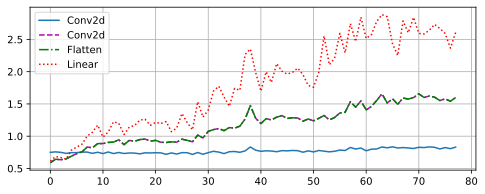

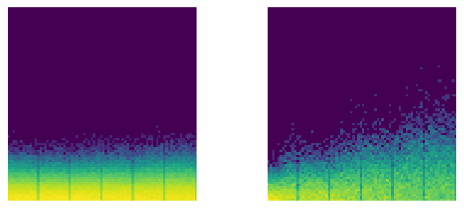

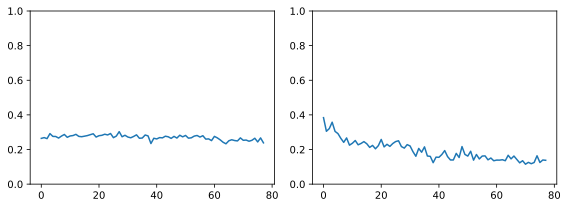

In [35]:
with Hooks(model, hook_stats) as hooks:
    learn = Learner(
        model=model,
        opt=torch.optim.Adam(model.parameters(), lr=1e-2),
        loss_func=nn.CrossEntropyLoss(),
        data=namedtuple('data', ['train_dl', 'valid_dl'])(train_loader, vali_loader),
    )

    runner = Runner(cb_funcs=[
        partial(AvgStatsCallback, None),
        partial(BatchTransformXCallback, lambda x: x.view(-1,1,16,16))
    ])
    
    runner.fit(3, learn)
    
    figsize = (8, 3)
    legends = []
    X = []
    for h in hooks:
        if hasattr(h, 'hook_stats'):
            legends.append(h.module._get_name())
            X.append([i.item() for i in h.hook_stats[0]])
    nb_d2l_utils.plot(list(range(len(X[0]))), X, legend=legends, figsize=figsize)
    
    legends = []
    X = []
    for h in hooks:
        if hasattr(h, 'hook_stats'):
            legends.append(h.module._get_name())
            X.append([i.item() for i in h.hook_stats[1]])
    nb_d2l_utils.plot(list(range(len(X[0]))), X, legend=legends, figsize=figsize)
    
    plt = nb_d2l_utils.plt
    fig, axes = plt.subplots(1,2, figsize=figsize)
    for ax,h in zip(axes.flatten(), hooks[:2]):
        ax.imshow(get_hist(h.hook_stats[2]), origin='lower')
        ax.axis('off')
    plt.tight_layout()
    
    fig,axes = plt.subplots(1,2, figsize=figsize)
    for ax,h in zip(axes.flatten(), hooks[:2]):
        ax.plot(get_min(h.hook_stats[2]))
        ax.set_ylim(0,1)
    plt.tight_layout()